**Soft Actor Critic (SAC) Reinforcement Leraning Model**
---
**Etudiants : Anaële BAUDANT-COJAN, Pierre BILLAUD, Edouard DUCLOY**<br>
Encadrement : Mai NGUYEN, Damien BOUCHABOU<br>
Cours IA705 - Apprentissage pour la robotique, Master spécialisé IA, Telecom Paris – ENSTA, mai 2024

In [1]:
import numpy as np
import os
import torch
from numpy import load
import cv2

from pypot.creatures import PoppyTorso
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from pypot.creatures.ik import IKChain
from pypot.primitive.move import Move
from pypot.primitive.move import MovePlayer

# custom libraries
# from PoppyEnv import PoppyEnv
from utils.skeleton import *
from utils.quaternion import *
from utils.blazepose import blazepose_skeletons
from utils.video_capturing import take_video, get_video_details, plot_skeletons_video_xyz, preprocess_skeletons, plot_3d_hand_trajectory, get_poppy_skeletons

# import model
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise

# Import environment
import gymnasium as gym
from gymnasium import spaces
# from Poppy_Env import PoppyEnv
from Poppy_Env_edouard_anaele import PoppyEnv


## Poppy Presentation
Poppy humanoid robot is a humanoid robot that can be used with its hardware platform or with the CoppeliaSim simulator. 
- Poppy uses pypot for control. It is a python library : http://poppy-project.github.io/pypot/. 
- On the top of pypot are libraries for Poppy creatures : https://github.com/poppy-project
- Gymnasium environment is used to create a dedicated Poppy Environment for the training

We use Blaze Pose for human pose estimation, this pretrained model is very efficient getting 3D coordinates (x,y,z) of key points in the body (see article https://arxiv.org/abs/2006.10204 and source code https://github.com/google/mediapipe)

This file summarizes our approach and the work we have done. We have been very largely inspired by the article :*"Signs of Language: Embodied Sign Language Fingerspelling Acquisition from Demonstrations for Human-Robot Interaction"* by Federico Tavella, Aphrodite Galata, Angelo Cangelosi, published in September 2022, https://arxiv.org/abs/2209.05135. This article describes a very similar learning tesk for sign language, and studies 2 reinforcement algorithm to learn how to sign letters from A to F. We have first trained Soft Actor Critic (SAC) and Proximal Policy Optimisation (PPO) model. We have then focused on the SAC model, which gave the best results. We have also Explored XXX and YYY models, but with many implementation difficulties (we needed to adjust environment for each model)

**SUMMARY :**<br>
**1/ Capturing video, visualisation skeletons and preprocessing skeletons**<br>
**2/ Creating an Environment with Gymnasium for Poppy torso**<br>
**3/ Train different Reinforcement Learning models (SAC is presented in this notebook and gave best results)**

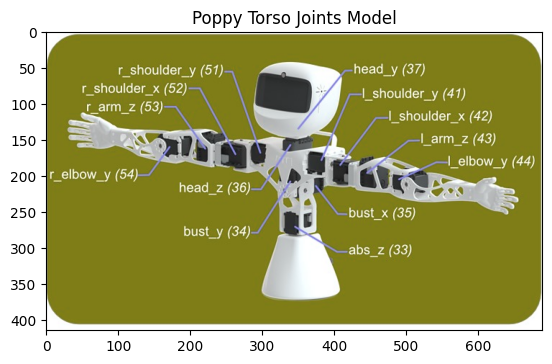

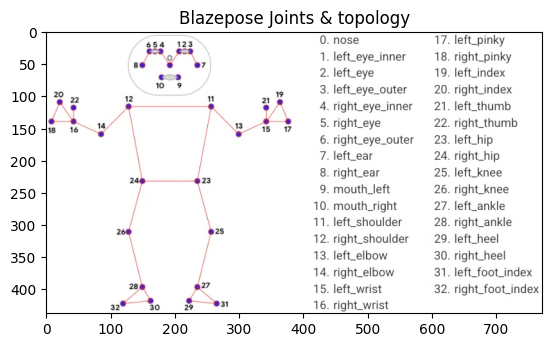

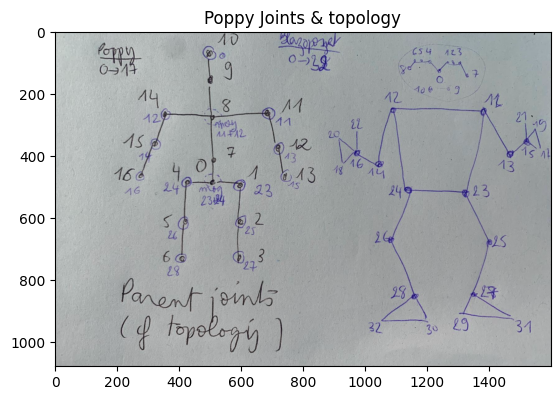

In [2]:
poppy_torso = cv2.imread('./poppy_torso_joints_model.jpg')
plt.imshow(poppy_torso)
plt.title('Poppy Torso Joints Model')
plt.show()

blazepose_joints= cv2.imread('./blazepose_mediapipe_joints.webp')
plt.imshow(blazepose_joints)
plt.title('Blazepose Joints & topology')
plt.show()

poppy_joints= cv2.imread('./poppy_joints_topology.jpg')
plt.imshow(poppy_joints)
plt.title ('Poppy Joints & topology' )
plt.show()



## Getting started

For to get started, we recommend the **2 tutorials we have made** :
- tutorial_video_capturing.ipynb : to explain how to get the targets from a video and preprocess data 
- tutorial_poppy_embodiment.ipynb : to learn how to use Coppelia Sim and give instruction to Poppy

You can also refer to the notebook provided by Mai and Damien ***sujet_upper_body_imitation.ipynb*** for installation

# Project instructions

Your task is to use the reinforcement learning and inverse reinforcement learning algorithms to learn how Poppy can imitate the movement, without using the inverse kinematics library.

You can use stable baselines or imitation libraries. You can also use your own implementation of the RL or iRL algorithm.
For using the libraries, it is recommended that you create your own gymnamsium environment (NB gymnasium is the new version of gym, it can be used in the previous code by replacing the import line by 'import gymnasium as gym').

- You can refer to the documentation by gym on https://gymnasium.farama.org/tutorials/gymnasium_basics/environment_creation/ or https://www.gymlibrary.dev/content/environment_creation/. They propose a tutorial python notebook
- You can also look at an example project with a similar robot, ErgoJr : https://github.com/fgolemo/gym-ergojr with the gym environment implementation : https://github.com/fgolemo/gym-ergojr/blob/master/gym_ergojr/envs/ergo_reacher_env.py

The action is the joint positions given to each of the motors.
The observation are the cartesian positions that can be accessed by commands like poppy.l_arm_chain.position.


You also need to decide on the reward function to be used.

Two interesting articles to get your inspiration can be read : 

- https://arxiv.org/abs/2209.05135
- https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8956326&casa_token=10GKHz8KJR8AAAAA:OZNWV-X7RxXJqLlRNqMBEtBg7jbH4fyy8pjDiMf5cOT65USEECinEMOiEVj0VW5sUDETHjGVgA&tag=1

In [3]:
# !pip install gym stable-baselines3 torch
# !pip install tqdm shimmy
# !pip install tensorboard

# 1/ Capture video, extract skeleton and get targets




## 1.1/ Exploration de Poppy et Coppelia Sim (tuto_poppy_embodiment.ipynb)

Nous avons tout d'abord **installé Poppy et Coppelia Sim** sur nos ordinateurs respectifs. Pour cela nous avons du gérer un certain nombre de conflits entre les librairies, du fait de l'utilisation de Python 3.8, notamment sur torch (résolu) et ikpy pour l'inverse kinematics et cuda (non résolus).

Nous avons ensuite exploré les différentes fonctionnalités de Poppy et Coppelia Sim. Nous avons appris à contrôler les moteurs de Poppy et à les déplacer dans différentes directions. Nous avons ainsi repéré les différents moteurs de Poppy et les différentes parties du corps qu'ils contrôlent. 

Nous avons constaté que Poppy buggait, **Coppélia Sim affichait des mouvements cahotiques (anormaux)**, lorsqu'il était demandé à poppy d'aller au délà de son actions space (soit par une mauvaise instruction, soit en heurtant la table ou se tapant la tête). Ainsi, si Poppy tend le bras (l_elbow ou r_elbow à 90°), il tape la table et le buste part très fortement en arrière (bust_y observé à -27° soit la valeur maximale). De même s'il leve le bras à 210° (l_shoulder_y ou r_sghoulder_x), meme si c'est techniquement possible, du fait d'une vitesse trop importante, il se tape la tête qui part avec le buste sur le coté. Ces deux instructions forcent sur les joints, et parfois le reset() a mis plus de 30 secondre à revenir à la position initiale.

Nous nous sommes rendu compte d'un **délai parfois important** nécessaire à la réalisation des mouvements de Poppy, meme lorsque Poppy ne se cognait pas la tete ou sur la table. CEla a généré des valeurs d'observation parfois très différentes des angles (actions) fournis aux moteurs. Nous avons donc choisi d'utiliser le **parametre wait=True** dans les fonctions de déplacement de Poppy pour éviter ces problèmes (poppy.goto_position(..., wait=True))

Nous avons donc recherché l'**action space** précis de Poppy dans Coppélia Sim, afin de resteindre le monde des possibles pour réduire les mouvements en anomalie et aussi optimiser le temps d'entraînement des modèles de renforcements. Nous avons obtenu les résultats suivant pour l'action_space:

            'l_elbow_y':    ( -60, 90)  bends the elbow
            'head_y':       ( -90, 90)  points the head down (>0) or up(<0)  
            'r_arm_z':      ( -50, 60)  rotates the arm around the shoulder-elbow axis 
            'head_z':       ( -90, 90)  rotates the head to the left (>0) or to the right (<0)  
            'r_shoulder_x': (-180, 15)  lifts elbow up or down
            'r_shoulder_y': (-210, 65)  moves shoulder forward or backward
            'r_elbow_y':    ( -60, 90)  straightens arms (90 full extension => -60 bent elbow)
            'l_arm_z':      ( -50, 60)  rotates the arm around the shoulder-elbow axis
            'abs_z':        ( -90, 90)  pivots to the left (>0) or to the right (<0) around the z-axis
            'bust_y':       ( -27, 22)  bends forward (>0) or backward (<0)
            'bust_x':       ( -20, 20)  leans to the left (>0) or to the right (<0)
            'l_shoulder_x': ( -15,180)  lifts elbow up or down
            'l_shoulder_y': (-180, 65)  moves shoulder forward or backward

Nous avons enfin analysé l'**observation space** de Poppy pour avoir une idée des ordres de grandeurs à attendre. Nos résultats nous ont montré que Poppy évoluait dans de tous petits intervalles, de l'ordre de -0.5 à 0.5 pour les positions cardinales.

## 1.2/ Enregistrement de mouvements <br>(tuto_video_capture.ipynb et utils/video_capturing.py)

Nous avons capturé des vidéo pour tester le modèle Blaze Pose, qui est un modèle pré-entrainé qui permet d'identifier sur un vidéo 37 points clés du corps humain. Nous avons analysé les **correspondances entre Blaze Pose et le robot Poppy Torso** tel que Poppy est défini dans pypot , à l'aide de la topologie de Poppy. La topologie de Poppy décrit en effet les relations entre les joints enfants (indice) et le joint parent (valeur). 

Ainsi pour :
        topology = [0, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15]

il existe la **hierarchie suivante entre les joints** :
        child joint (indice):  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
        parent joint (valeur): [0, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9,  8,  11, 12,  8, 14, 15]

        The connections between the joints are:
        Child joint 0 (Pelvis) is connected to parent joint 0 (Pelvis)
        Child joint 1 (Left hip) is connected to parent joint 0 (Pelvis)
        Child joint 2 (Left knee) is connected to parent joint 1 (Left hip)
        Child joint 3 (Left ankle) is connected to parent joint 2 (Left knee)
        Child joint 4 (Right hip) is connected to parent joint 0 (Pelvis)
        Child joint 5 (Right knee) is connected to parent joint 4 (Right hip)
        Child joint 6 (Right ankle) is connected to parent joint 5 (Right knee)
        Child joint 7 (Spine) is connected to parent joint 0 (Pelvis)
        Child joint 8 (Chest) is connected to parent joint 7 (Spine)
        Child joint 9 (Neck) is connected to parent joint 8 (Chest)
        Child joint 10 (Head) is connected to parent joint 9 (Neck)
        Child joint 11 (Left shoulder) is connected to parent joint 8 (Chest)
        Child joint 12 (Left elbow) is connected to parent joint 11 (Left shoulder)
        Child joint 13 (Left wrist) is connected to parent joint 12 (Left elbow)
        Child joint 14 (Right shoulder) is connected to parent joint 8 (Chest)
        Child joint 15 (Right elbow) is connected to parent joint 14 (Right shoulder)
        Child joint 16 (Right wrist) is connected to parent joint 15 (Right elbow)

Enfin nous avons chercher à **visualiser en 3D les squelettes humain et de Poppy** obtenus, pour s'assurer du bon fonctionnement du modèle pré-entrainé Blaze Pose, avec différentes lumières et couleurs. Blaze est très efficace (légèrement moins en terme de profondeur, mais cela reste très bon une fois le preprocessing réalisé).

Afin de tester les fonctions de **smoothing et d'interpolation**, nous avons créé des pseudo-vidéos à partir des squelettes dans pyplot, pour visualiser les effets:
        - plot_skeletons_video_xyz : affiche le squelette en 3D dans un espace "proportionnel" (avec les memes dimensions sur chaque axe)
        - plot_3d_hand_trajectory : affiche la trajectoire de la main droite et gauche en 3D (end-effectos des chaines cinématiques) dans un espace "proportionnel" (avec les memes dimensions sur chaque axe) et indique tous les 20 steps (par défaut) la position avec le numéro de step

## 1.3/ Préprocessing des données <br>(tuto_video_capturing.ipynb et video_capturing.py)

Enfin nous avons regroupé les étapes du preprocessing dans un fonction preprocessing, qui successivement :
        - ré-ordonne les axes du squelette
        - centre le squelette sur le pelvis
        - reoriente le squelette sur l'axe z (à l'aide de quaternion et des longueurs des os humains) : soit avec un angle fourni soit, de manière automatique (si ref_joint = Non)
        - centre le squelette sur le joint de son choix (par défaut = None)
        - lisse les positions des joints (coordonnées x,y,z)
        - interpole les positions des joints 

Nous avons adapté la fonction qui faisait une moyenne arithmétique des 2 dernières frame pour avoir une vraie moyenne mobiles, et retenu 5,puis finalement 10 frames. Nous avons aussi réutilisé la fonction qui réoriente automatiquement la colonne vertebrale vers le haut et le bassin de face dans utils/skeletons. Les paramètre par défaut angle= None et ref_joint = None permettent ainsi un **preprocessing totalement automatisé** donnant de très bon résultats.

Enfin grace au code fourni dans utils/skeletons.py et le notebook du TP nous avons défini une fonction qui **transpose le squelette humain aux dimension de Poppy** (là encore à l'aide des quaternions et des dimensions humaines et de poppy). Le recours au quarternion redresse la colonne à la verticale sur TOUT les frames (Poppy est donc figé au niveau des 2 joints du buste meme si un peu de randomness est ajouté). Cette fonction recentre aussi le squelette de Poppy sur le pelvis (il faut donc recenter sur le joint choisi avec center_skeleton() pour recentrer sur l'épaule gauche et entrainer un modèle uniquement sur le bras gauche)



In [9]:
# 1/ CAPTURE VIDEO
####################################################

# CAPTURE A 5 SECOND VIDEO

# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
# !!!  starts with arms bent slightly appart from body    !!!
# !!!  for good skeleton extraction (Poppy is on a table) !!!
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

# open camera (only if necessary to gain opening time)
cap = cv2.VideoCapture(0)
try:
    if not cap.isOpened():
        cap = cv2.VideoCapture(0)
except NameError:
    cap = cv2.VideoCapture(0)

# choose parameters
duration = 5    # length of video
delay = 3       # time before video starts
fps = 30        # frame per second
path = './resources/sample_videos/'  # path to save video 
format = 'mp4'  # format of video
filename = 'output' + '.' + format

# Capture video (unquote to use)
take_video(cap, filename=filename, path=path, duration=duration, fps=fps, delay=delay)

print("\nVideo details")
get_video_details(path + filename)

# close camera
# cap.release()




Camera will start recording in 3 seconds
Camera is open and capturing.
Video captured and saved successfully.

Video details
Video: ./resources/sample_videos/output.mp4 
Frames per Second: 30.0
Total number of frames: 128
Duration of video in seconds: 4.266666666666667
Image dimensions: (480, 640, 3)


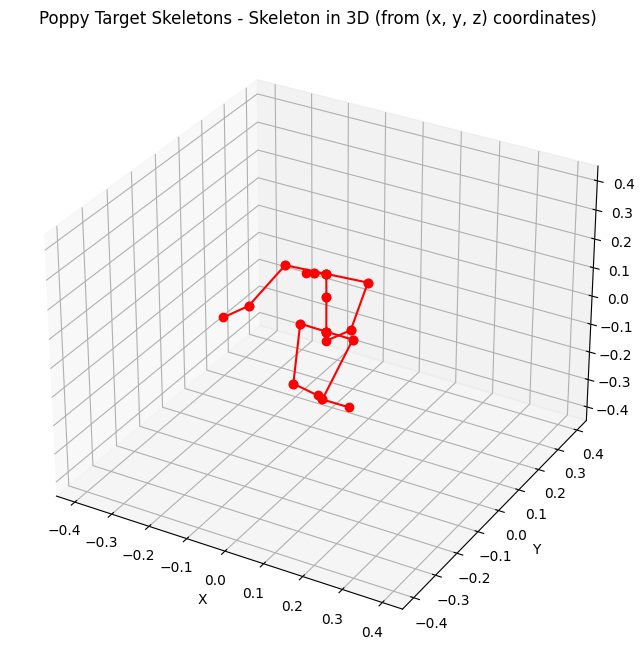

In [14]:
# 2/ EXTRACT SKELETONS
####################################################

# Choose video file
path_video = './resources/sample_videos/' # './resources/sample_videos/'
path_skeletons = './resources/sample_poppy_skeletons/'
file = 'output.mp4' 
# file = 'mai1.mov'
# file = 'anaele_bent_arms_1.mp4' # 'anaele_hoolahoop.mp4' # anaele_kneel_down.mp4  anaele_twist.mp4 anaele_hoolahoop.mp4 
video = path_video + file

# Extract humain skeleton from video and preprocess
# ----------------------------------------------------------
skeletons = blazepose_skeletons(video)
topology = [0, 0, 1, 2, 0, 4, 5, 0, 7, 8, 9, 8, 11, 12, 8, 14, 15] # connections between joints (see bellow)
skeletons_pp = preprocess_skeletons(skeletons, topology, angle= np.pi/4*0 ,ref_joint = 0 , smoothing_n=10, interpolation_factor = 1 )
torch.save(skeletons_pp, path_skeletons + file[:-4] + '_skeletons.pt')
plot_skeletons_video_xyz(skeletons_pp, topology, proportionnal=1, title='Preprocessed HUMAN Skeletons - ')

# Get Poppy target skeleton from human skeleton and save
#----------------------------------------------------------
poppy_lengths = torch.Tensor([0.0, 0.07, 0.18, 0.19, 0.07, 0.18, 0.19, 0.12, 0.08, 0.07, 0.05, 0.1, 0.15, 0.13, 0.1, 0.15, 0.13])
poppy_skeletons = get_poppy_skeletons(skeletons_pp, topology, poppy_lengths)
torch.save(poppy_skeletons, path_skeletons + file[:-4] + '_test_poppy_skeletons.pt')
plot_skeletons_video_xyz(poppy_skeletons, topology, proportionnal=1, title='Poppy Target Skeletons - ')



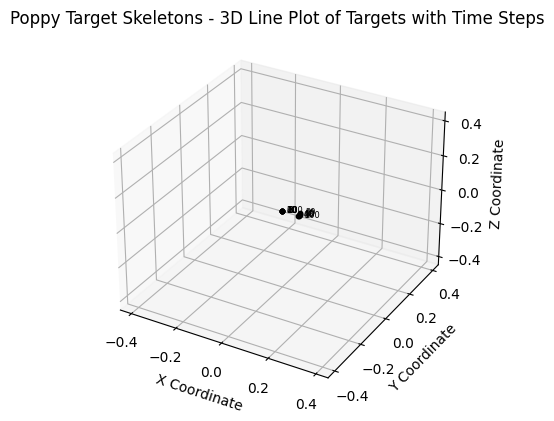

In [15]:
plot_3d_hand_trajectory(poppy_skeletons, period=20, title='Poppy Target Skeletons - ')


# 2/ Creating Environment

We have created an environnment PoppyEnv() which inherit from Gymnasium lybrary.

The **environment main purposes** are to :
- launch an instance of Poppy torso on Copplia Sim (when initialising)
- import the file Poppy must be trainend on
- give instruction on actions to be performed to get observation for RL model
- define a step function to train our models

It is in our environment that we have defined :
- the **action_space** : mooves that poppy motors can perform (on angle for each 13 motors of Poppy)
- the **observation space** : where Poppy can reach out to (3D space with x,y,z coordinates)
- the **reward function** : it is based, for each step, on distances between Poppy's wrist targets and observations, and also penalty when abnormal moovements or positions of the bust and head are observed.

These are important elements in defining the Markov Process to train appropriately (and not too slowly our models)

In [16]:
# Import environment
from pypot.creatures import PoppyTorso
import gymnasium as gym
from gymnasium import spaces
# from Poppy_Env import PoppyEnv
from Poppy_Env_edouard_anaele import PoppyEnv

In [17]:
# 1/ Launch Coppelia Sim and environment
####################################################

# Launch Coppelia Sim (space will appear empty)
# --------------------------------------------

# Start a Poppy instance
#------------------------
env = PoppyEnv()
vec_env = DummyVecEnv([lambda: env])  

# Define file to use as target
# ----------------------------
path_skeletons = './resources/sample_poppy_skeletons/'
file = 'anaele_bent_arms_1_test_poppy_skeletons.pt' # 'mai1_poppy_skeletons.pt' #'anaele_bent_arms_0_poppy_skeletons.pt' #'Edouard_0_poppy_skeletons.pt'
data_path = path_skeletons + file
env.get_target(file_name = data_path)
print("target shapes:",env.targets.shape)
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#
#      Table can be manually removed from COPPELIA SIM
#      (to avoid Poppy hitting the table and slowing down trainging)
#
# !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

Hello, I am Poppy!
loading targets from :  ./resources/sample_poppy_skeletons/anaele_bent_arms_1_test_poppy_skeletons.pt
target shapes: torch.Size([31, 17, 3])


In [18]:
# env.reset()

In [19]:
# 2/ UNDERSTANDING THE ORDER OF POPPY'S MOTORS FOR TRIANING
# ---------------------------------------------------------

# Moove Poppy to any angle for one of the 13 motors
actions_dict = { 'l_shoulder_x': 20.0,
                'l_shoulder_y': 15.0,
                'l_arm_z': 10.0,
                'l_elbow_y': 5.0,
            }
actions = env.get_mooves_array_from_dict(actions_dict) # transform dictionary into 13 dimension motor array
motor_order = ['l_elbow_y','head_y','r_arm_z','head_z','r_shoulder_x','r_shoulder_y','r_elbow_y','l_arm_z','abs_z','bust_y','bust_x','l_shoulder_x','l_shoulder_y']
print('actions (in the same order as Poppy\'s motors):\n', motor_order,'\n',actions)

# reorder for convenience during traing in bust, head, leaft arm right arm order (in x,y,z order)
# order = ['l_elbow_y','head_y','r_arm_z','head_z','r_shoulder_x','r_shoulder_y','r_elbow_y','l_arm_z','abs_z','bust_y','bust_x','l_shoulder_x','l_shoulder_y']
OBSERVATION_order = [10,9,8,1,3,11,12,7,0,4,5,2,6]
print('\nACTIONS (same order as observations):\n', [actions[i] for i in OBSERVATION_order])

# execute action
env.poppy_goto(actions)

# Get observed targets and joints positions
targets, joints_pos = env.get_observation()
print('OBSERVATIONS - joints_position (13 motors - 3 for bust + 2 for head + 4 for left arm + 4 for right arm):\n',joints_pos) # 5 first angles (bust + head) should stay at 0 (no action space defined)
# if first 5 angles are not 0, Poppy has hit himself or banged in the table, creating a reaction in bust ans head !!!
print('OBSERVATIONS - targets (left wrist x,y,z coordinates and right wrist x,y,z coordinates):\n',np.round(targets,2))

# Reset Poppy to initial position
# env.reset()

actions (in the same order as Poppy's motors):
 ['l_elbow_y', 'head_y', 'r_arm_z', 'head_z', 'r_shoulder_x', 'r_shoulder_y', 'r_elbow_y', 'l_arm_z', 'abs_z', 'bust_y', 'bust_x', 'l_shoulder_x', 'l_shoulder_y'] 
 [5.0, 0, 0, 0, 0, 0, 0, 10.0, 0, 0, 0, 20.0, 15.0]

ACTIONS (same order as observations):
 [0, 0, 0, 0, 0, 20.0, 15.0, 10.0, 5.0, 0, 0, 0, 0]
OBSERVATIONS - joints_position (13 motors - 3 for bust + 2 for head + 4 for left arm + 4 for right arm):
 [ 0. -0. -0.  0.  0. 20. 15. 10.  5.  0.  0. -0.  0.]
OBSERVATIONS - targets (left wrist x,y,z coordinates and right wrist x,y,z coordinates):
 [ 0.19 -0.13  0.04 -0.1  -0.18  0.07]


# 3/ Training

In [20]:
import numpy as np
import torch
from numpy import load
import matplotlib.pyplot as plt
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

# import visualisation tools
from utils.video_capturing import plot_skeletons_video_xyz, plot_3d_hand_trajectory

# import model
from stable_baselines3 import SAC
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.noise import NormalActionNoise



In [23]:
# Function to evaluate the model and get average reward for each episode
def evaluate_model(model, env, num_episodes=3):
    '''
    Evaluate the model on a given number of episodes
    Inputs:
    - model: the trained model
    - env: the environment
    - num_episodes: the number of episodes to evaluate the model
    Returns: prints training information and returns the mean reward
    '''
    episode_rewards = []
    episode_stats = []
    obs = env.reset()

    for e in range(0,num_episodes-1):

        episode_reward = 0
        done = False

        while not done:
            
            action, _ = model.predict(obs, deterministic=False)  # obs is a tuple ([...6 values...], dtype=float32)
            obs, reward, done, info = env.step(action)
            episode_reward += reward
            episode_rewards.append(reward)
        
        # Calculate statistics
        episode_rewards_np = np.array(episode_rewards)
        episode_rewards_np = np.round(episode_rewards_np,2)
        
        print(f"Episode: {e+1} Mean reward: {episode_rewards_np.mean()}, Std reward: {episode_rewards_np.std()}, Min reward: {episode_rewards_np.min()}, Max reward: {episode_rewards_np.max()}")

    # Calculate statistics
    print('episode_rewards:', type(episode_rewards), len(episode_rewards), episode_rewards)
    mean_reward = np.mean(episode_rewards)
    std_reward = np.std(episode_rewards)
    min_reward = np.min(episode_rewards)
    max_reward = np.max(episode_rewards)
    print(f"Mean Reward: {mean_reward}, Std Reward: {std_reward}, Min Reward: {min_reward}, Max Reward: {max_reward}")
    # Save statistics to list
    episode_stats.append([mean_reward, std_reward, min_reward, max_reward])

    return episode_rewards, episode_stats

In [22]:
# 3/ TRAINING THE MODEL
#############################################

# Define device to be used 
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define Model Hyperparameters
#-----------------------------
num_episodes=3
entropy_coefficient = 0.5  # Increase to boost exploration
n_actions = env.action_space.shape[-1]
action_noise_std = 0.1  # Standard deviation of the Gaussian noise
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=action_noise_std * np.ones(n_actions))

# Create the SAC model (from stable baseline)
# ------------------------------------------
model = SAC("MlpPolicy", vec_env, verbose=1, 
            ent_coef=entropy_coefficient, 
            action_noise=action_noise,
            device=device)

# Train model on episodes & number of steps (frames in the data)
# --------------------------------------------------------------
env.reset()
print("Number of steps:", env.num_steps)
model.learn(total_timesteps = env.num_steps) #, log_interval=10, eval_freq=1000, n_eval_episodes=5, eval_log_path='./logs/')

# Save model (for further training...)
model.save("sac_poppy_model")

# Evaluate model after training
mean_rewards, episode_stats = evaluate_model(model, vec_env)

# Save episode_stats (for further training)
import pickle
with open('episode_stats.pkl', 'wb') as f:
    pickle.dump(episode_stats, f)



Using cpu device
loading targets from :  ./resources/sample_poppy_skeletons/anaele_bent_arms_1_test_poppy_skeletons.pt
Number of steps: 30


c:\users\anaele.baudant\onedrive - befive\_master ia\_cours\ia705 apprentissage pour la robotique\poppy\venv\lib\site-packages\stable_baselines3\common\policies.py:400: RuntimeWarning: invalid value encountered in divide
  return 2.0 * ((action - low) / (high - low)) - 1.0


0-0 Reward: 0.86 Joints: [0.0, -0.0, -0.0, 0.0, 0.0, 70.7, -5.4, -30.0, 45.0, -94.4, -120.2, -28.5, 86.9]
0-1 Reward: 0.88 Joints: [0.0, 0.0, 0.0, 0.0, 0.0, 17.4, -18.5, 19.0, -34.0, -53.0, -124.0, 19.3, 90.0]
0-2 Reward: 0.81 Joints: [0.0, -0.0, 0.0, 0.0, 0.0, 32.8, -62.4, 6.3, 59.0, -167.4, -43.1, 1.3, 7.8]
0-3 Reward: 0.75 Joints: [0.0, 0.0, 0.0, 0.0, 0.0, 138.0, 38.4, -15.7, 72.6, -72.0, -69.4, -45.0, 0.3]
0-4 Reward: 1.05 Joints: [0.0, -0.0, -0.0, 0.0, 0.0, 52.7, 47.8, 1.6, 46.9, -101.1, -59.6, 52.8, -38.1]
0-5 Reward: 0.81 Joints: [0.0, 0.0, 0.0, 0.0, 0.0, 6.6, -85.5, -20.4, 9.3, -94.1, -86.2, 4.3, 82.4]
0-6 Reward: 0.98 Joints: [0.0, -0.0, -0.0, 0.0, 0.0, 83.5, 11.1, 24.4, -32.8, -56.0, -69.3, 4.7, -30.8]
0-7 Reward: 1.07 Joints: [0.0, -0.0, 0.0, 0.0, 0.0, 63.0, -147.3, -9.4, -25.9, -29.8, -10.7, 36.7, 56.7]
0-8 Reward: 0.83 Joints: [0.0, -0.0, -0.0, 0.0, 0.0, 179.9, -22.8, 30.0, 56.9, -170.4, -119.0, 23.6, -37.1]
0-9 Reward: 1.03 Joints: [0.0, -0.0, -0.0, 0.0, 0.0, 180.1, -137.

In [25]:
print("episode_stats",episode_stats)
print("mean_rewards",len(mean_rewards))


episode_stats [[0.9632925, 0.16927734, 0.70611465, 1.6134355]]
mean_rewards 60


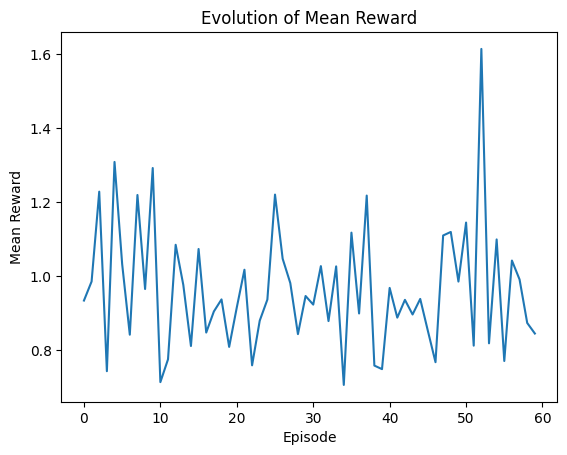

In [26]:
# Tracer l'évolution de la récompense moyenne
plt.plot(mean_rewards)
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Evolution of Mean Reward')
plt.show()

**Additionnal training if necessary**
---

In [ ]:
# COMPLETE TRAINING AT A LATER STAGE
# -----------------------------------

# Load the saved model
model = SAC.load("sac_poppy_model")

# Load the saved episode_stats
with open('episode_stats.pkl', 'rb') as f:
    episode_stats_initial = pickle.load(f)

# Training for additional episodes
additional_episodes = 10
model.learn(total_timesteps=env.num_steps, num_episodes=additional_episodes)

# Save the updated model
model.save("sac_poppy_model_updated")

# Evaluate the updated model
mean_rewards = evaluate_model(model, vec_env)

# concatenate episode_stats
episode_stats = episode_stats_initial + episode_stats

# Plot the evolution of the mean reward
plt.plot(mean_rewards)
plt.xlabel('Episode')
plt.ylabel('Mean Reward')
plt.title('Evolution of Mean Reward (Updated Model)')
plt.show()
